# Recommender systems project

Nazariy Vysokinskyi, Dmytro Ponomarov, Maksym Sarana

### Exploratory Data Analysis

The exploratory data analysis is in this document in the [Appendix A](#appendix_A_exploratory_data_analysis).

### Development & Experiment Journal

#### Repo structure

- [`data/`](data) - directory with original data, files with train and test ids, external data
- [`models/`](models) - directory includes an abstract model class and implementation of the models
- [`evaluation/`](evaluation) - directory includes the Evaluation Framework class and a file with data prepocessing functions
- [`task/`](task) - directory with the original task description
- [`run.py`](run.py) - CLI to run the Evaluation Framework
- [`requirements.txt`](requirements.txt) - Python reqirements
- [`report.ipynb`](report.ipynb) - current document as a jupyter notebook
- [`report.html`](report.html) - current document as an HTML file
- [`README.md`](README.md) - repo readme file

#### Evaluation Framework

##### Offline Implementation

We are going to predict the same rating (from 1 to 5) as we have in the dataset, i.e. solve a regression task. The natural metrics for continuous or ordinal predictions are MAE, MSE and RMSE. We have chosen MAE and RMSE to have the same scale as ratings.

*Train-test split strategy* is realized and described in detail in the [Appendix B](#appendix_B_train_test_split). We splitted the data onto train and test sets in this notebook since it is relatively "research" task, save the ids to the files `data/train.ids` and `data/test.ids` (tab-separated files with pairs `<UserID>\t<MovieID>`). The Evaluation Framework reads these files and splits the data during the initialization.

##### Online Methodology

The Online Methodology is described in the [Appendix C](#appendix_C_online_evaluation_methodology).

#### Additional data

To improve the contant-based algorithm we scrapped the movie descriptions from the [imdb.com](https://imdb.com/) web-site and saved to the `data/movie_descriptions.dat` file. The code and details are in the [Appendix D](#appendix_D_scrap_movie_descriptions). 

### Comparison of models and approaches

```
---------------------------------------------
Testing model: RandomRecommender

Metrics:
MAE:  1.541
RMSE: 1.915
---------------------------------------------
---------------------------------------------
Testing model: ContentBaseRecommender
Use TF-IDF features: True
TF-IDF max features: 50

Metrics:
MAE:  1.424
RMSE: 1.659
---------------------------------------------
---------------------------------------------
Testing model: CollaborativeRecommender
Top K: 30

Metrics:
MAE:  1.019
RMSE: 1.257
---------------------------------------------
---------------------------------------------
Testing model: MatrixFactorizationRecommender
Num factors: 50

Metrics:
MAE:  1.022
RMSE: 1.261
---------------------------------------------
```

### Summary & Conclusions

In this project we implemented several recommender algorithms and found, that the best performance (lower MAE and RMSE) has the collaborative filtering. The error metrics (MAE, RMSE) for the collaborative filtering are 1.5 times better (lower) than the random rank model (baseline).

<a id='appendix_A_exploratory_data_analysis'></a>
## Appendix A. Exploratory data analysis

In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from datetime import datetime
import re
import matplotlib.pyplot as plt

In [2]:
from evaluation.read_data import read_movies, read_ratings, read_users
from evaluation.read_data import get_user_age, get_user_occupation
from evaluation.read_data import encode_movie_genres, extract_movie_year, get_rating_datetime

Read data

In [3]:
users = read_users('data/users.dat')
movies = read_movies('data/movies.dat')
ratings = read_ratings('data/ratings.dat')

In [4]:
print('Number of users:', users.shape[0])
print('Number of movies:', movies.shape[0])
print('Number of ratings:', ratings.shape[0])

Number of users: 6040
Number of movies: 3883
Number of ratings: 1000209


### A1-1. Users analysis

Process data, extract additional info

In [5]:
users_mod = users.join(get_user_age(), on='Age').join(get_user_occupation(), on='Occupation')

In [6]:
users_mod.head()

,UserID,Gender,Age,Occupation,ZipCode,AgeGroup,OccupationDetailed
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


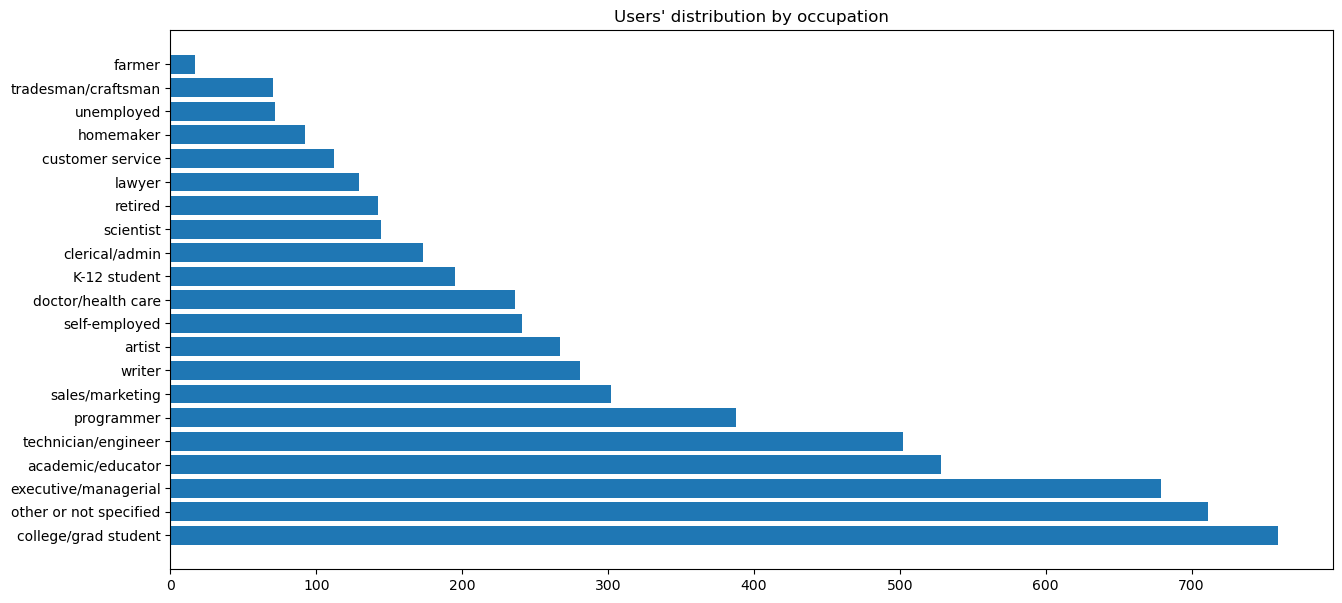

In [7]:
plt.figure(figsize=(15, 7))
plt.title("Users' distribution by occupation")
occupation_stats = users_mod.OccupationDetailed.value_counts()
plt.barh(y=occupation_stats.index, width=occupation_stats);

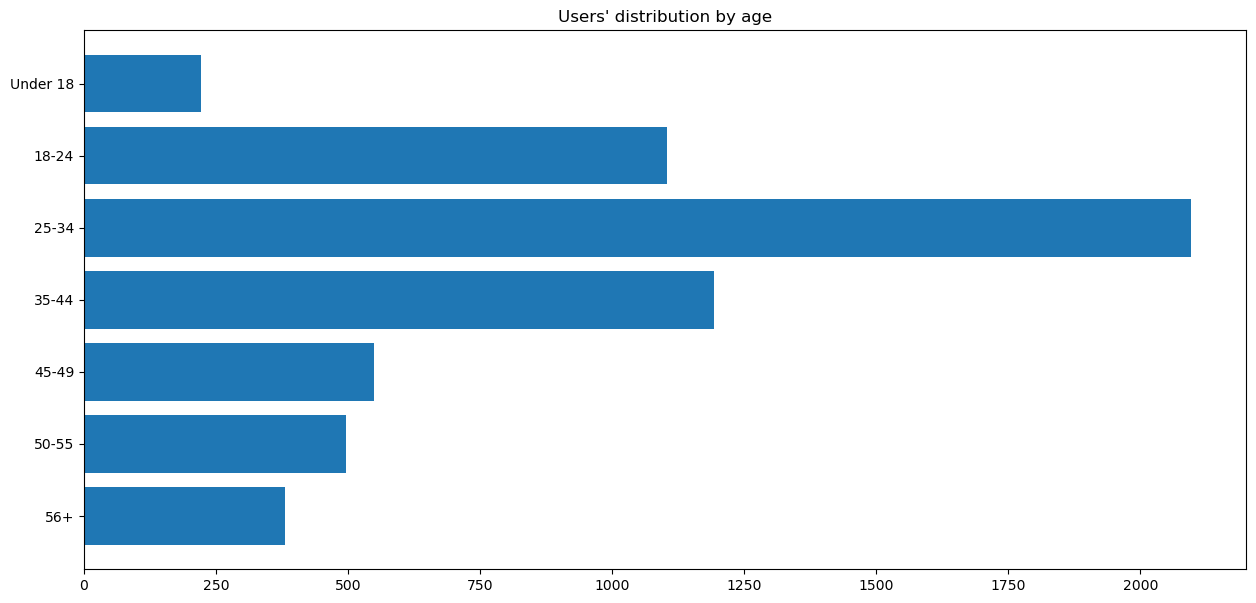

In [8]:
plt.figure(figsize=(15, 7))
plt.title("Users' distribution by age")
age_stats = users_mod.AgeGroup.value_counts()
age_stats = age_stats.reindex(get_user_age().to_list()[::-1])
plt.barh(y=age_stats.index, width=age_stats);

### A1-2. Movies analysis

In [9]:
movies_mod = extract_movie_year(encode_movie_genres(movies, drop_genres_column=True), remove_year_from_title=True)

In [10]:
movies_mod.head()

,MovieID,Title,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,...,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western,Year
0,1,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


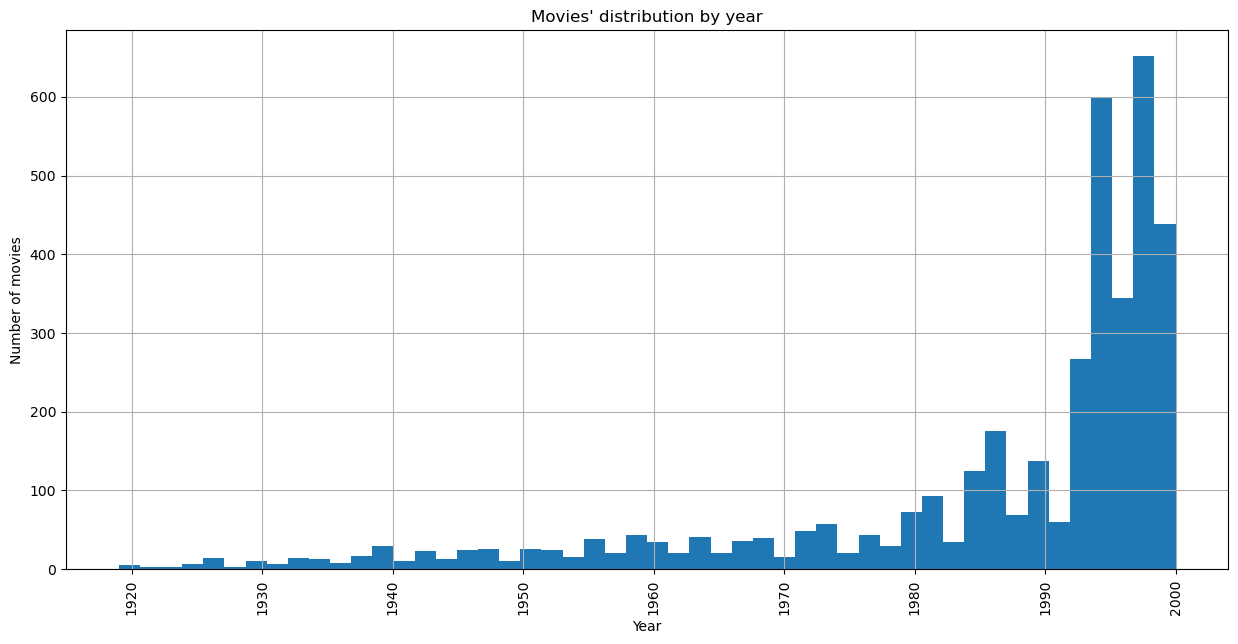

In [11]:
plt.figure(figsize=(15, 7))
plt.title("Movies' distribution by year")
plt.xlabel('Year')
plt.ylabel('Number of movies')
movies_mod.Year.hist(bins=50);
plt.xticks(rotation=90);

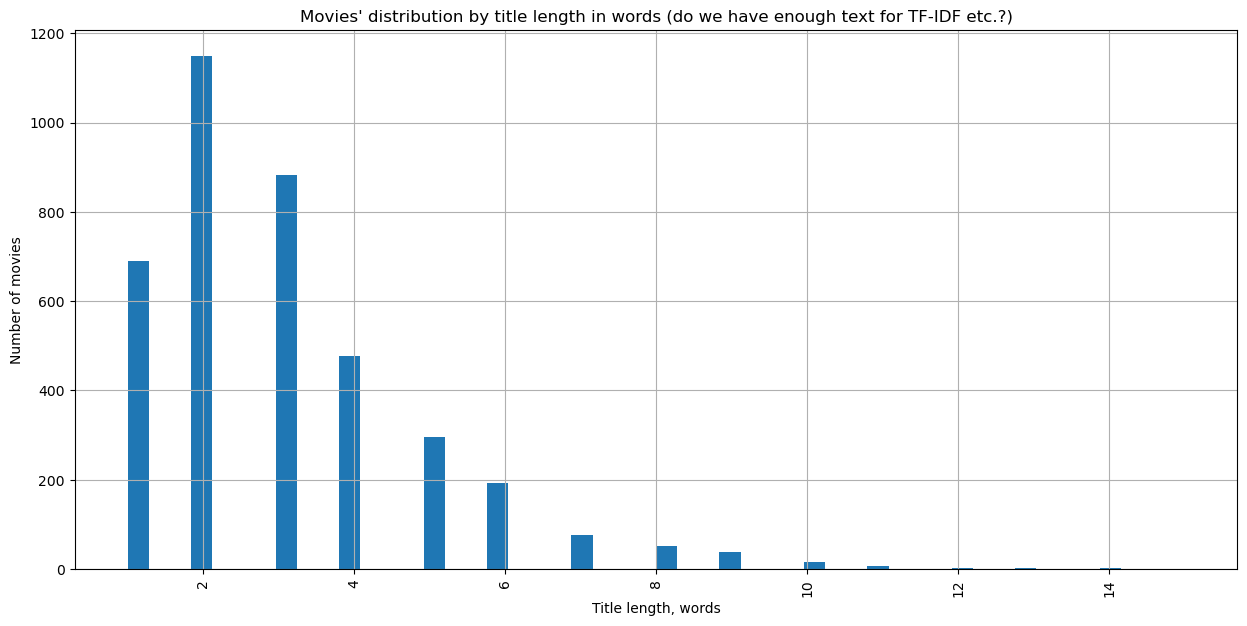

In [12]:
plt.figure(figsize=(15, 7))
plt.title("Movies' distribution by title length in words (do we have enough text for TF-IDF etc.?)")
plt.xlabel('Title length, words')
plt.ylabel('Number of movies')
movies_mod.Title.map(lambda x: len(x.split())).hist(bins=50);
plt.xticks(rotation=90);

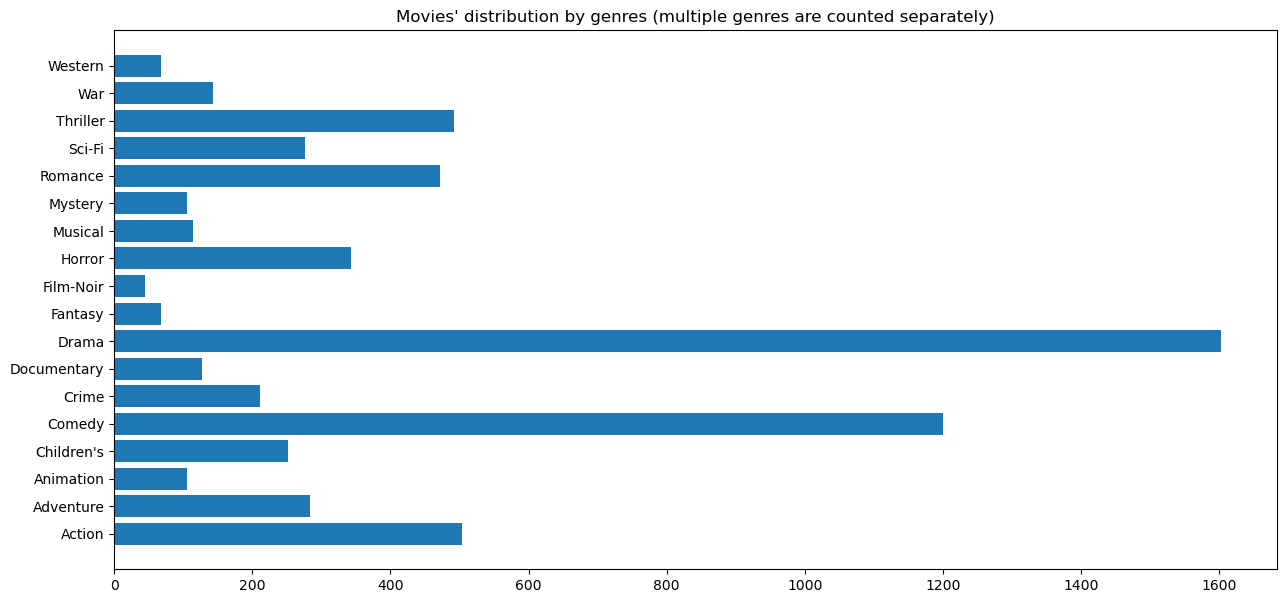

In [13]:
plt.figure(figsize=(15, 7))
plt.title("Movies' distribution by genres (multiple genres are counted separately)")
genres_sums = movies_mod[[x for x in movies_mod.columns if x.startswith('Genre_')]].sum()
plt.barh(y=genres_sums.index.map(lambda x: x.split("_", maxsplit=1)[1]), width=genres_sums);

## A1-3. Ratings analysis

Process data, extract additional info

In [14]:
ratings_mod = get_rating_datetime(ratings, remove_timestamp_column=False)

In [15]:
ratings_mod.head()

,UserID,MovieID,Rating,Timestamp,DateTime
0,1,1193,5,978300760,2001-01-01 00:12:40
1,1,661,3,978302109,2001-01-01 00:35:09
2,1,914,3,978301968,2001-01-01 00:32:48
3,1,3408,4,978300275,2001-01-01 00:04:35
4,1,2355,5,978824291,2001-01-07 01:38:11


Distribution in time:

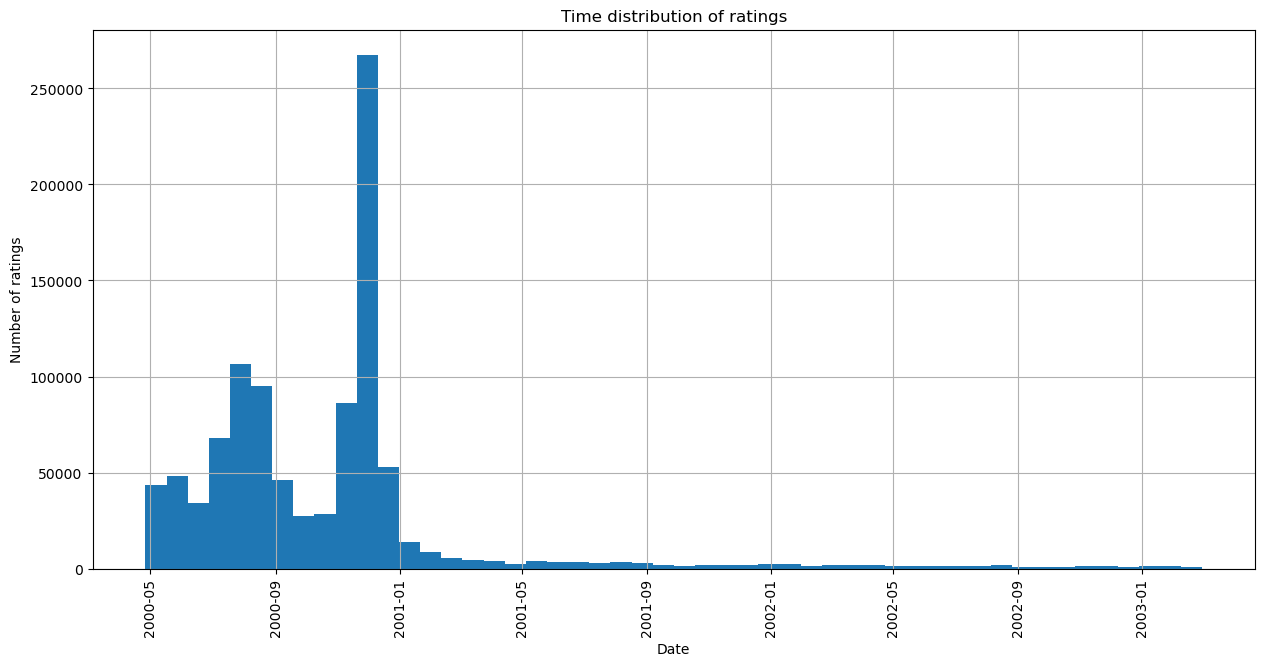

In [16]:
plt.figure(figsize=(15, 7))
plt.title("Time distribution of ratings")
plt.xlabel('Date')
plt.ylabel('Number of ratings')
ratings_mod.DateTime.hist(bins=50)
plt.xticks(rotation=90);

Distribution of a number of ratings per user and per movie:

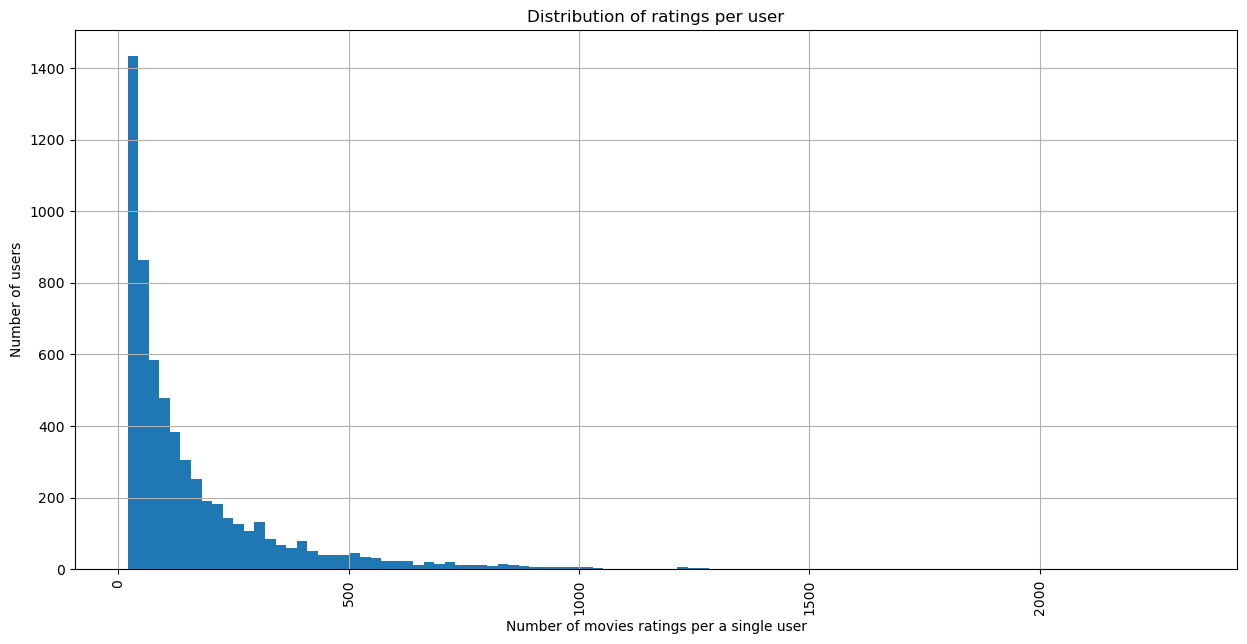

In [17]:
plt.figure(figsize=(15, 7))
plt.title("Distribution of ratings per user")
plt.xlabel('Number of movies ratings per a single user')
plt.ylabel('Number of users')
ratings_mod.groupby('UserID')['MovieID'].count().hist(bins=100)
plt.xticks(rotation=90);

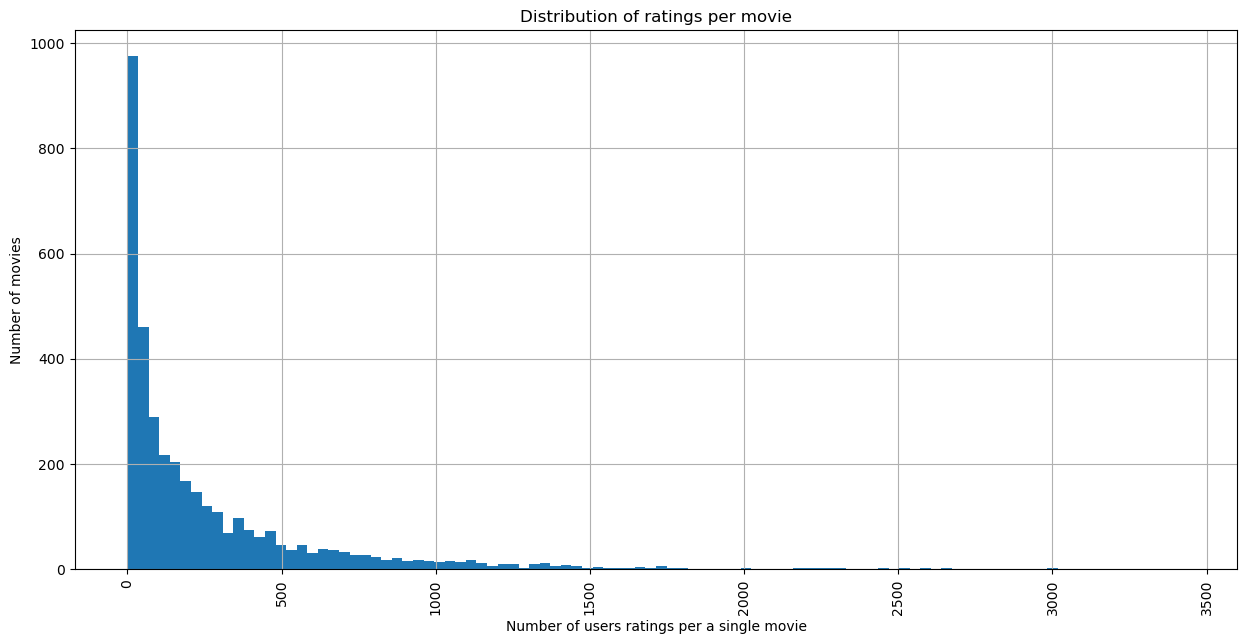

In [18]:
plt.figure(figsize=(15, 7))
plt.title("Distribution of ratings per movie")
plt.xlabel('Number of users ratings per a single movie')
plt.ylabel('Number of movies')
ratings_mod.groupby('MovieID')['UserID'].count().hist(bins=100)
plt.xticks(rotation=90);

Do we have doubled rating for the same users and movies?

In [19]:
ratings_mod.groupby(['UserID', 'MovieID'])['Rating'].count().max() > 1

False

How the new user acquisition is distributed in time?

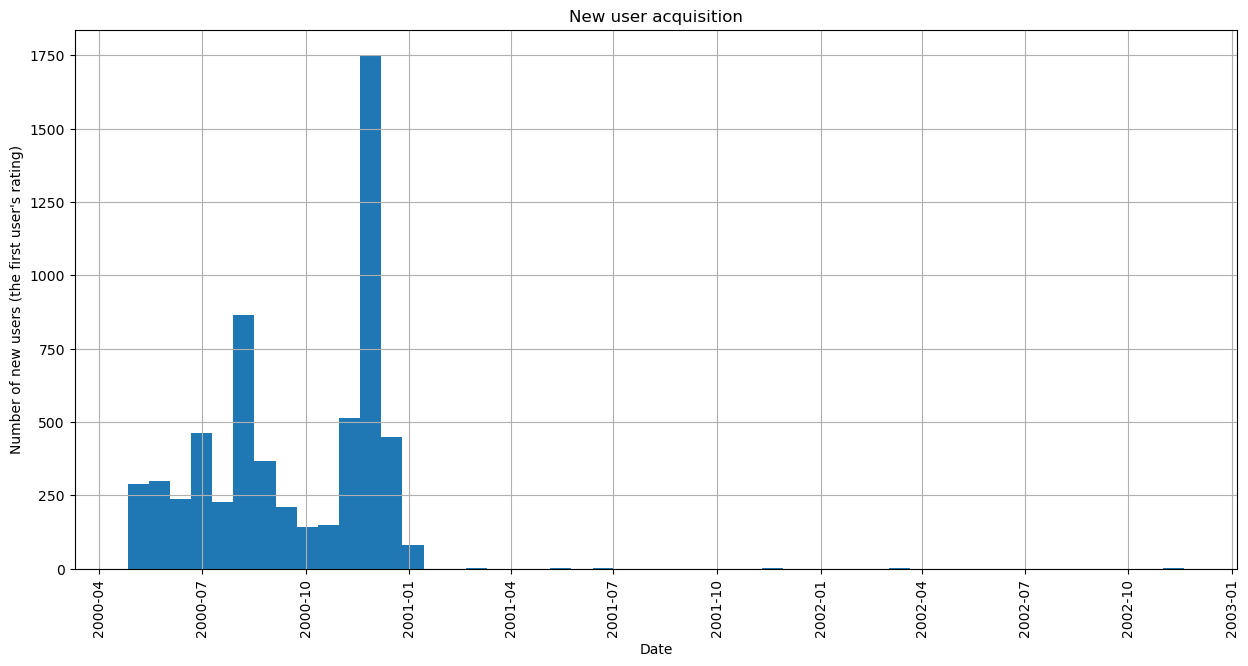

In [20]:
plt.figure(figsize=(15, 7))
plt.title("New user acquisition")
plt.xlabel('Date')
plt.ylabel("Number of new users (the first user's rating)")
ratings_mod.groupby('UserID')['DateTime'].min().hist(bins=50)
plt.xticks(rotation=90);

And with more bins:

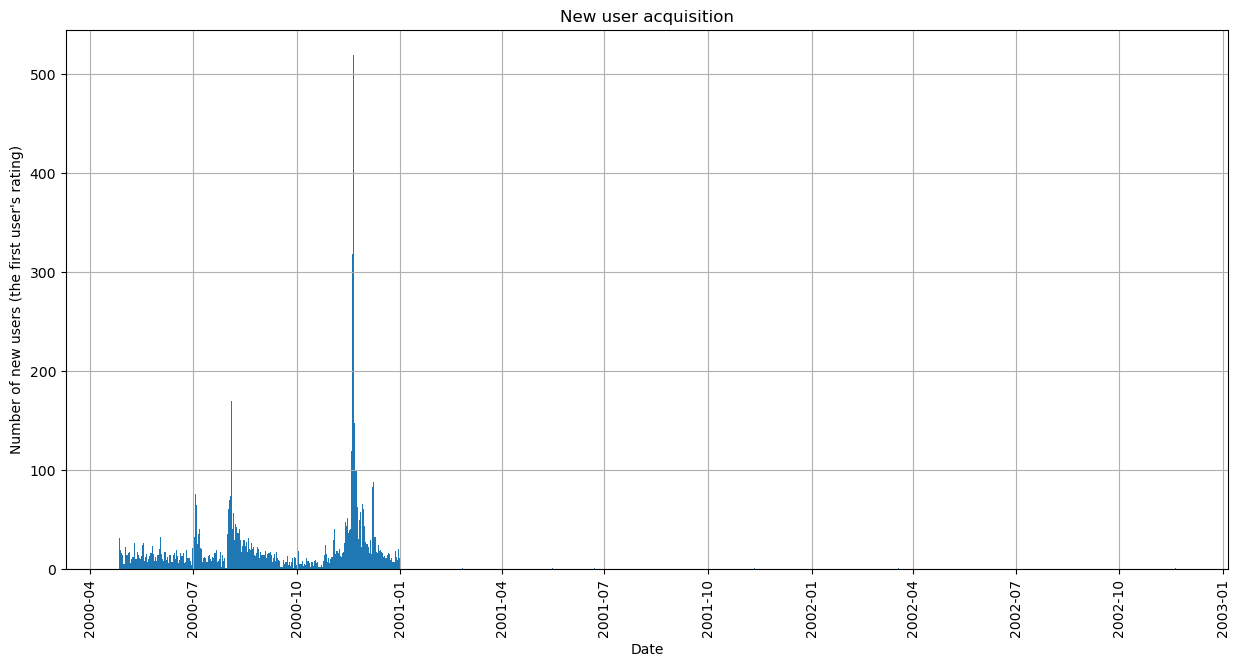

In [21]:
plt.figure(figsize=(15, 7))
plt.title("New user acquisition")
plt.xlabel('Date')
plt.ylabel("Number of new users (the first user's rating)")
ratings_mod.groupby('UserID')['DateTime'].min().hist(bins=1000)
plt.xticks(rotation=90);

<a id='appendix_A_median_new_users'></a>
Let's find a median (to remove the outliers) number of new users aquired in the active period (from May-2000 till December-2000):

In [22]:
filter_range = (datetime.strptime("2000-05-01T00:00:00", "%Y-%m-%dT%H:%M:%S"), datetime.strptime("2001-01-01T00:00:00", "%Y-%m-%dT%H:%M:%S"))

ratings_filtered = ratings_mod[ratings_mod.DateTime.map(lambda x: filter_range[0] <= x < filter_range[1])]

users_first_ratings = ratings_filtered.groupby('UserID').min()[['DateTime']]
users_first_ratings['Date'] = users_first_ratings.DateTime.map(lambda x: x.date())

users_first_ratings.groupby('Date').count().median()

DateTime    15.0
dtype: float64

<a id='appendix_B_train_test_split'></a>
# Appendix B. Train/test split

In [23]:
test_set_threshold = datetime.strptime("2000-11-23T00:00:00", "%Y-%m-%dT%H:%M:%S")

test_index = ratings_mod.DateTime >= test_set_threshold

train_ratings = ratings_mod.loc[~test_index]
test_ratings = ratings_mod.loc[test_index]

print(f'Train set: {train_ratings.shape[0]} ratings, {train_ratings.shape[0] / ratings_mod.shape[0]:.2%}')
print(f'Test set: {test_ratings.shape[0]} ratings, {test_ratings.shape[0] / ratings_mod.shape[0]:.2%}')

Train set: 715114 ratings, 71.50%
Test set: 285095 ratings, 28.50%


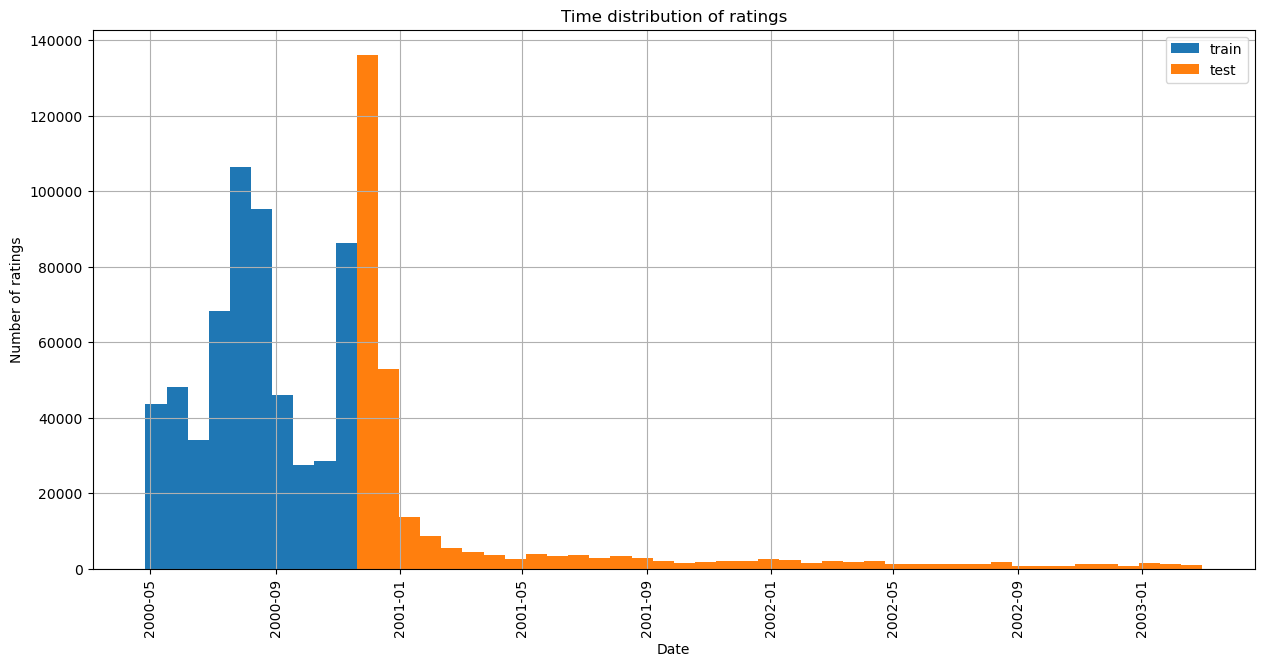

In [24]:
plt.figure(figsize=(15, 7))
plt.title("Time distribution of ratings")
plt.xlabel('Date')
plt.ylabel('Number of ratings')
_, bins  = np.histogram(ratings_mod.DateTime.map(lambda x: x.timestamp() / 60 / 60 / 24), 50)
train_ratings.DateTime.hist(bins=bins, label='train')
test_ratings.DateTime.hist(bins=bins, label='test')
plt.xticks(rotation=90);
plt.legend();

A number of new users and new movies in the test set:

In [25]:
new_test_users = test_ratings[~test_ratings.UserID.isin(train_ratings.UserID.unique())].UserID.unique()
new_test_movies = test_ratings[~test_ratings.MovieID.isin(train_ratings.MovieID.unique())].MovieID.unique()

print(f'Test set has {new_test_users.shape[0] / test_ratings.UserID.unique().shape[0]:.2%} of new users ({new_test_users.shape[0]})')
print(f'Test set has {new_test_movies.shape[0] / test_ratings.MovieID.unique().shape[0]:.2%} of new movies ({new_test_movies.shape[0]})')

Test set has 49.75% of new users (1099)
Test set has 1.74% of new movies (62)


So, the `test` set contains the long right tail of data with a lot of new users (49.75%) and is much different from the main range of data. Most of recommender algorithms don't perform well with new users and this may significantly corrupt the model evaluation results.

To make the test set better representive let's remove the data outliers. To do this we

- remove data from the long tail

- drop new users above normal level ([we found in the exploratory part](#appendix_A_median_new_users) that it is normal to have 15 new users a day)

In [26]:
right_cut_off_threshold = datetime.strptime("2001-01-01T00:00:00", "%Y-%m-%dT%H:%M:%S")
test_set_threshold = datetime.strptime("2000-11-01T00:00:00", "%Y-%m-%dT%H:%M:%S")
normal_level_of_new_users_in_test_set = (right_cut_off_threshold - test_set_threshold).days * 15

test_index = (ratings_mod.DateTime >= test_set_threshold) & (ratings_mod.DateTime < right_cut_off_threshold)
train_index = (ratings_mod.DateTime < test_set_threshold) & (ratings_mod.DateTime < right_cut_off_threshold)

train_ratings = ratings_mod.loc[train_index]
test_ratings = ratings_mod.loc[test_index]

new_test_users = test_ratings[~test_ratings.UserID.isin(train_ratings.UserID.unique())].UserID.unique()
users_to_remove_from_test = np.random.choice(new_test_users, len(new_test_users) - normal_level_of_new_users_in_test_set, replace=False)

test_index = test_index & (~test_ratings.UserID.isin(users_to_remove_from_test))
test_ratings = ratings_mod.loc[test_index]

not_used_ratings = ratings_mod.loc[~(test_index | train_index)]

print(f'Train set: {train_ratings.shape[0]} ratings, {train_ratings.shape[0] / (train_ratings.shape[0] + test_ratings.shape[0]):.2%}')
print(f'Test set: {test_ratings.shape[0]} ratings, {test_ratings.shape[0] / (train_ratings.shape[0] + test_ratings.shape[0]):.2%}')

Train set: 500422 ratings, 77.88%
Test set: 142094 ratings, 22.12%


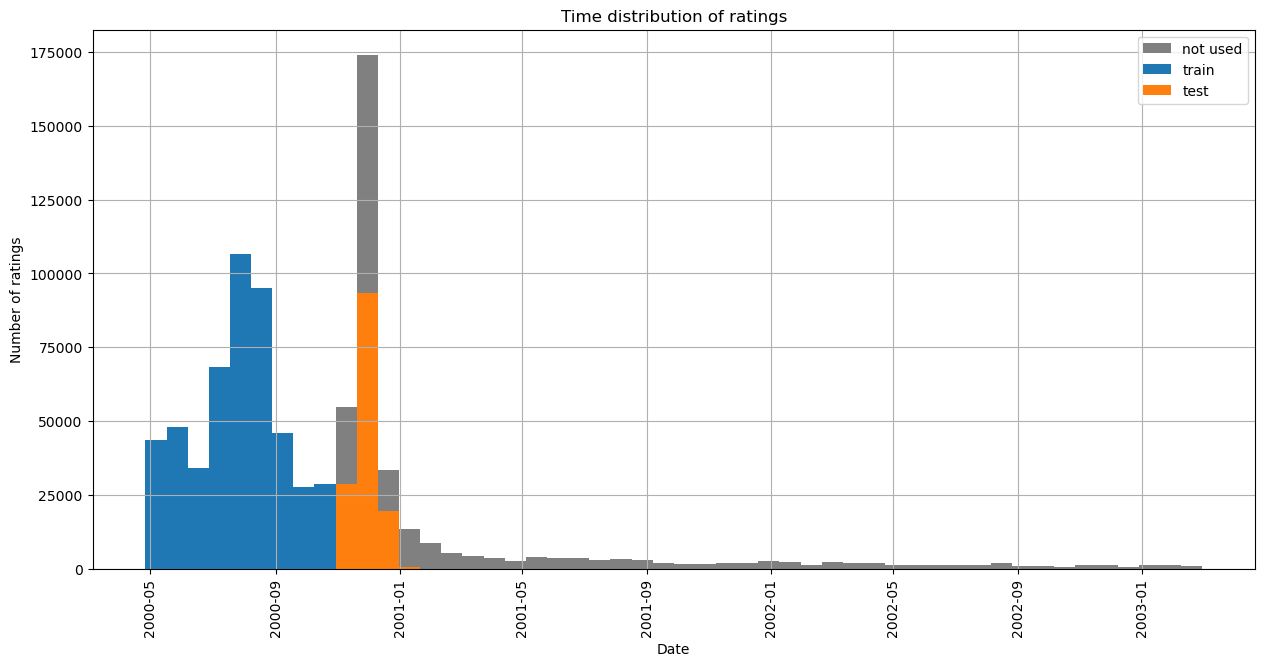

In [27]:
plt.figure(figsize=(15, 7))
plt.title("Time distribution of ratings")
plt.xlabel('Date')
plt.ylabel('Number of ratings')
_, bins  = np.histogram(ratings_mod.DateTime.map(lambda x: x.timestamp() / 60 / 60 / 24), 50)
not_used_ratings.DateTime.hist(bins=bins, label='not used', color='grey')
train_ratings.DateTime.hist(bins=bins, label='train')
test_ratings.DateTime.hist(bins=bins, label='test')

plt.xticks(rotation=90);
plt.legend();

In [82]:
new_test_users = test_ratings[~test_ratings.UserID.isin(train_ratings.UserID.unique())].UserID.unique()
new_test_movies = test_ratings[~test_ratings.MovieID.isin(train_ratings.MovieID.unique())].MovieID.unique()

print(f'Test set has {new_test_users.shape[0] / test_ratings.UserID.unique().shape[0]:.2%} of new users ({new_test_users.shape[0]})')
print(f'Test set has {new_test_movies.shape[0] / test_ratings.MovieID.unique().shape[0]:.2%} of new movies ({new_test_movies.shape[0]})')

Test set has 72.39% of new users (915)
Test set has 1.62% of new movies (55)


Save train / test ids for the evaluation framework

In [88]:
def save_ids(fn, df):
    """
    The function writes pairs of user and movie ids to a tab-separated file
    :param fn: filename
    :param df: pandas dataframe
    """
    with open(fn, 'w') as f:
        for _, r in df.iterrows():
            f.write(f"{r.UserID}\t{r.MovieID}\n")

In [87]:
save_ids(fn='data/train.ids', df=train_ratings)
save_ids(fn='data/test.ids', df=test_ratings)

In [89]:
! head ../data/train.ids

2779	3936
2779	1256
2779	2997
2779	589
2779	1
2779	1269
2779	1419
2779	1276
2779	1278
2779	1284


<a id='appendix_C_online_evaluation_methodology'></a>
# Appendix C. Online evaluation methodology

## Evaluation techniques:

#### A/B Testing:
In A/B testing users would be divided into two groups: a control group and an experimental group. The control group receives movie recommendations from the current system (baseline), while the experimental group is exposed to recommendations from the new system being evaluated. By comparing the performance metrics (e.g., click-through rates) between the two groups, we can determine the effectiveness of the new recommender system.

#### Online Learning:
The movie recommender system continuously updates its recommendations based on user interactions and feedback. As users provide ratings or engage with movie recommendations, the system updates its model in real-time. This allows the system to adapt and improve its suggestions based on the most recent user behavior.

#### Multi-Armed Bandit:
The users receive different recommendation options (arms) and we observe their interactions. Initially, the system may explore different movie suggestions to gather data on user preferences, and over time, it shifts to exploiting the most promising recommendations based on the observed feedback.



## Methodology:

#### Data Preparation:
Prepare the datasets. Ensure that the data is clean and relevant.
  
#### Online Environment Setup:
Set up the online environment where the recommender system will be deployed and tested (e.g. live website).

#### Randomized Control:
Randomly divide users into two groups: control and experimental. Ensure that the groups are large enough to yield statistically significant results.

#### Metrics Selection:
Choose appropriate evaluation metrics, such as click-through rates, user engagement, or movie ratings. These metrics should align with the specific objectives of our recommender system.

#### Data Collection:
Collect relevant data on user interactions, ratings, and any other relevant metrics.

#### Statistical Analysis:
After the testing period, perform statistical analysis to compare the performance metrics between the control and experimental groups. Use appropriate statistical tests (e.g., t-test, chi-square test) to determine if there are significant differences in the performance of the two systems.

#### Iterative Improvement:
Based on the results of the online evaluation, make necessary adjustments to the new recommender system and repeat the testing process if required. Iteratively refine the system until satisfactory performance is achieved.

#### User Feedback:
Gather qualitative feedback from users regarding their experience with the recommender system. "Did recommendations become better?", "Are your recommendations relevant?"

#### Deployment:
Document the performance improvements achieved. If the new system performs better than the baseline, deploy it in the production environment.

<a id='appendix_D_scrap_movie_descriptions'></a>
# Appendix D. Movie descriptions WEB-scraping

In [37]:
from bs4 import BeautifulSoup
import json
import html
import requests

To map the movie names with the IMDb ids we downloaded the `title.basics.tsv.gz` file from the [IMDb Non-Commercial Datasets](https://developer.imdb.com/non-commercial-datasets/).

In [29]:
! curl -o /tmp/title.basics.tsv.gz https://datasets.imdbws.com/title.basics.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  167M  100  167M    0     0  9032k      0  0:00:18  0:00:18 --:--:-- 9088k


In [30]:
! gzip -d /tmp/title.basics.tsv.gz

In [33]:
imdb_title_basics = pd.read_csv('/tmp/title.basics.tsv', sep='\t', low_memory=False)

In [34]:
imdb_title_basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10050932,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10050933,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10050934,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10050935,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


The following `map_movie_ids` function tries to find movies in the IMDb dataset by title and year, and return the IMDb id. It tries several forms of titles (the primary and original, with/without `, The` at the ending or with puting `the` at the beginning. If multiple records found with the same title and year, there is a priority of record type (`movie`, `tvMovie`, `tvSeries` etc.).

In [36]:
def map_movie_ids(imdb_df, movies_df):
    
    def strip_the(x):
        if x.endswith(', The'):
            return x[:-5]
        return x
        
    def start_with_the(x):
        if x.endswith(', The'):
            return 'The ' + x[:-5]
        return x    
    
    imdb_df = imdb_df.loc[(imdb_df.startYear != '\\N')].astype({'startYear': 'int64'}).copy()
    imdb_df.originalTitle = imdb_df.originalTitle.str.lower()
    imdb_df.primaryTitle = imdb_df.primaryTitle.str.lower()
    movies_df = movies_df[['MovieID', 'Title', 'Year']]
    
    res = {}
    for fn in [lambda x: x, strip_the, start_with_the]:
        for imdb_title_column in ['originalTitle', 'primaryTitle']:

            movies_df_filtered = movies_df[~movies_df.MovieID.isin(res)].copy()
            movies_df_filtered['Title'] = movies_df_filtered['Title'].str.strip().map(fn).str.lower()

            merged = pd.merge(imdb_df, movies_df_filtered,  how='inner',
                              left_on=[imdb_title_column, 'startYear'],
                              right_on = ['Title', 'Year'])[['tconst', 'titleType', 'MovieID']]
            
            for movie_id, data in merged.groupby('MovieID'):
                if data.shape[0] == 1:
                    res[movie_id] = data.tconst.iloc[0]
                else: # deal with duplicates
                    for t in ['movie', 'tvMovie', 'tvSeries', 'tvMiniSeries', 'tvEpisode', 'short',
                              'tvShort', 'tvSpecial', 'video', 'tvPilot']:
                        data_filtered = data[data.titleType == t]
                        if data_filtered.shape[0] > 0:
                            res[movie_id] = data_filtered.tconst.iloc[0]
                            break
    
    return res

In [39]:
mapped_movie_ids = map_movie_ids(
    imdb_df=imdb_title_basics, 
    movies_df=movies_mod
)

In [40]:
mapped_movie_ids

{1: 'tt0114709',
 2: 'tt0113497',
 3: 'tt0113228',
 4: 'tt0114885',
 5: 'tt0113041',
 6: 'tt0113277',
 7: 'tt0114319',
 8: 'tt0112302',
 9: 'tt0114576',
 10: 'tt0113189',
 12: 'tt0112896',
 13: 'tt0112453',
 14: 'tt0113987',
 15: 'tt0112760',
 16: 'tt0112641',
 17: 'tt0114388',
 18: 'tt0113101',
 19: 'tt0112281',
 20: 'tt0113845',
 21: 'tt0113161',
 22: 'tt0112722',
 23: 'tt0112401',
 24: 'tt0114168',
 25: 'tt0113627',
 26: 'tt0114057',
 27: 'tt0114011',
 28: 'tt26933001',
 31: 'tt0112792',
 32: 'tt0114746',
 33: 'tt0114952',
 34: 'tt0112431',
 35: 'tt0112637',
 36: 'tt0112818',
 37: 'tt0112286',
 38: 'tt0113442',
 39: 'tt0112697',
 40: 'tt0112749',
 41: 'tt0114279',
 42: 'tt0112819',
 43: 'tt0114272',
 44: 'tt0113855',
 45: 'tt0114681',
 46: 'tt0113347',
 48: 'tt0114148',
 49: 'tt0114916',
 51: 'tt0559192',
 52: 'tt0113819',
 53: 'tt0110299',
 55: 'tt0113158',
 56: 'tt0113541',
 57: 'tt0113321',
 61: 'tt0116260',
 62: 'tt0113862',
 63: 'tt0116126',
 64: 'tt0118002',
 65: 'tt0115683',


In [43]:
print(f"We processed {len(mapped_movie_ids)} ({len(mapped_movie_ids) / movies_mod.shape[0]:.2%}) movies from {movies_mod.shape[0]}")

We processed 3131 (80.63%) movies from 3883


The following function scrapes the movie info from the imdb.com web-site:

In [ ]:
def get_movie_data(imdb_id):
    HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}
    r = requests.get(f'https://www.imdb.com/title/{imdb_id}/', headers=HEADERS)
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, 'html.parser')
        ld_json = soup.find('script', type='application/ld+json')
        if ld_json:
            return json.loads(ld_json.text)

In [47]:
get_movie_data('tt0093996')

{'@context': 'https://schema.org',
 '@type': 'Movie',
 'url': 'https://www.imdb.com/title/tt0093996/',
 'name': 'Slumber Party Massacre II',
 'image': 'https://m.media-amazon.com/images/M/MV5BMjFjMTUyOTAtMDg4Yy00YjE4LWE1ODgtODM3ZDAwZWZhN2UyXkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_.jpg',
 'description': 'Courtney Bates, the younger sister of Valerie, and her friends go to their condo for a weekend getaway, but Courtney can&apos;t get rid of the haunting feeling that a supernatural rockabilly driller killer is coming to murder them all.',
 'review': {'@type': 'Review',
  'itemReviewed': {'@type': 'Movie',
   'url': 'https://www.imdb.com/title/tt0093996/'},
  'author': {'@type': 'Person', 'name': 'Fella_shibby'},
  'dateCreated': '2021-03-21',
  'inLanguage': 'English',
  'name': 'Terrible n boring.',
  'reviewBody': 'I first saw this in the early 90s on a vhs. Revisited it recently. The actual movie is of 69 mins but the runtime is 76 mins with the start n end credits. The deal is, nothing happe

And finally we scrap the descriptions (it takes about 1.5 hour):

In [187]:
descriptions = {}

for i, (k, v) in enumerate(mapped_movie_ids.items()):
    
    for _ in range(3):  # retry 3 times
        movie_data = get_movie_data(v)
        if movie_data is not None:
            descriptions[k] = movie_data.get('description')
            break
    
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [200]:
len([k for k, v in descriptions.items() if v is not None])

3105

Write the descriptions to a file (with unescaping the HTML-escapes):

In [204]:
with open('/data/movie_descriptions.dat', 'w') as f:
    for k, v in descriptions.items():
        if v is not None:
            f.write(f"{k}::{html.unescape(v)}\n")

In [28]:
! head data/movie_descriptions.dat

1::A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy's bedroom.
2::When two kids find and play a magical board game, they release a man trapped in it for decades - and a host of dangers that can only be stopped by finishing the game.
3::John and Max resolve to save their beloved bait shop from turning into an Italian restaurant, just as its new female owner catches Max's attention.
4::Based on Terry McMillan's novel, this film follows four very different African-American women and their relationships with men.
5::George Banks must deal not only with his daughter's pregnancy, but also with his wife's.
6::A group of high-end professional thieves start to feel the heat from the LAPD when they unknowingly leave a clue at their latest heist.
7::An ugly duckling having undergone a remarkable change, still harbors feelings for her crush: a carefree playboy, but not before his business-focused brother has something to say abo